<a href="https://www.kaggle.com/code/satou001i4/resys-project?scriptVersionId=209521228" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

# Data Preparation

In [2]:
path = '../input/fashion-product-images-dataset/fashion-dataset/'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path) # list content of dataset
dirs_names

['images.csv', 'images', 'styles.csv', 'styles', 'fashion-dataset']

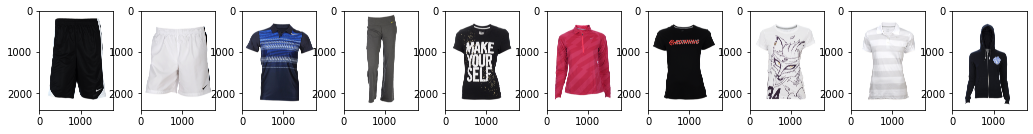

In [3]:
# Plot samples 
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path + 'images/100' + str(i) +'.jpg') # Assign images ids
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [4]:
styles_df = pd.read_csv(path + "styles.csv", nrows=6000, error_bad_lines=False) # Read 6000 product and drop bad lines 
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
print(styles_df.shape)
styles_df.head(5)

(6000, 11)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


<AxesSubplot:>

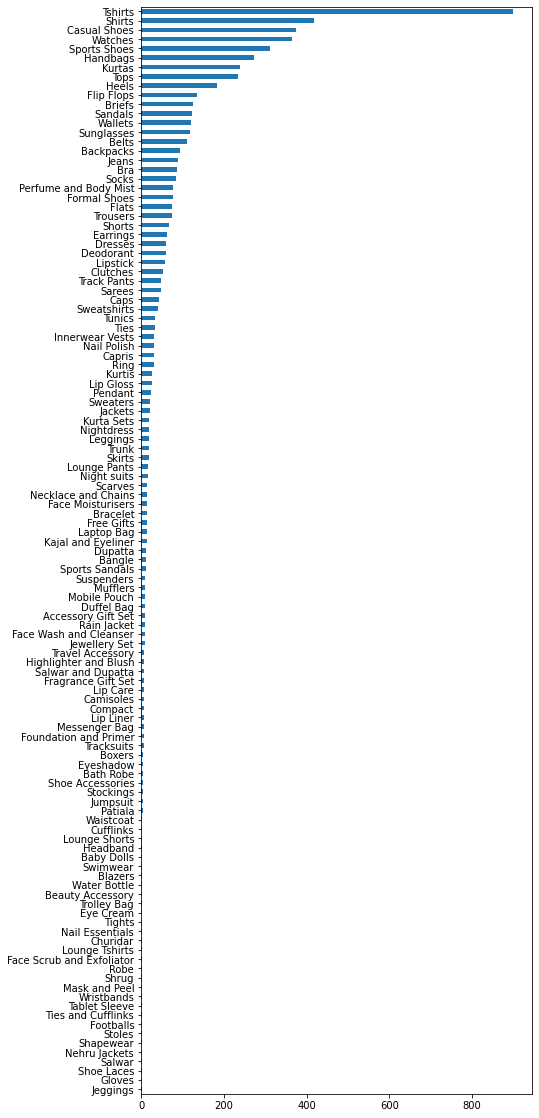

In [5]:
plt.figure(figsize=(7,20))
styles_df.articleType.value_counts().sort_values().plot(kind='barh')

# Modeling and Get Image Embeddings

In [6]:
img_width, img_height, chnls = 100, 100, 3

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow import keras

# Define image dimensions and channels
img_width, img_height, chnls = 224, 224, 3  # Example values

# Specify the local path to the weights
weights_path = '/kaggle/input/vgg16weigtht/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

vgg16 = VGG16(include_top=False, weights=weights_path, input_shape=(img_width, img_height, chnls))
vgg16.trainable = False
vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
vgg16_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
def img_path(img):
    """ Take image name(id) and return the complete path of it """
    return path + 'images/' + img

def predict(model, img_name):
    """ Load and preprocess image then make prediction """
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

In [9]:
def get_embeddings(df, model):
    """ Return a dataframe contains images features """
    df_copy = df
    df_embeddings = df_copy['image'].apply(lambda x: predict(vgg16_model, x).reshape(-1))
    df_embeddings = df_embeddings.apply(pd.Series)
    return df_embeddings

df_embeddings = get_embeddings(styles_df, vgg16_model)

In [10]:
df_embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.000000,0.0,0.000000,0.000000,0.492509,0.000000,0.380022,1.029977,0.824850,1.881124,...,1.748321,5.421374,1.126911,0.826925,3.168820,1.223185,0.000000,1.358081,0.634137,1.150601
1,0.854611,0.0,1.240914,0.000000,0.934158,0.000000,0.269950,1.695614,0.000000,0.470493,...,1.860231,5.939581,0.817809,1.421019,3.803939,0.466040,1.615005,2.007827,0.749531,1.300926
2,2.967391,0.0,1.777314,3.039529,0.702563,0.071668,0.000000,0.210411,0.000000,2.450745,...,1.753913,0.554499,1.826138,0.000000,0.000000,0.788966,0.354467,0.135371,1.088857,0.216424
3,0.754873,0.0,0.437628,0.000000,2.020579,0.965172,0.679213,0.355313,0.000000,0.541646,...,1.841461,5.974853,0.445932,0.528150,3.354457,0.651119,1.409211,0.827068,0.749195,1.179148
4,0.000000,0.0,0.000000,0.000000,0.501922,0.000000,0.000000,0.363474,1.076603,0.000000,...,1.858248,2.836306,1.079191,0.000000,1.168057,0.503840,0.000000,0.143603,0.747501,0.540434


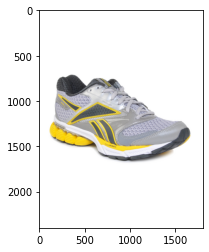

In [11]:
url="../input/fashion-product-images-dataset/fashion-dataset/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

In [12]:
sample_image = predict(vgg16_model, '10037.jpg')
sample_image.shape

(1, 512)

In [13]:
df_sample_image = pd.DataFrame(sample_image)  
print(df_sample_image)

        0    1         2         3         4         5    6         7    \
0  2.418416  0.0  2.099834  1.727748  0.389754  0.782242  0.0  0.467931   

        8         9    ...       502       503       504      505       506  \
0  0.140692  8.007483  ...  2.101223  0.410726  1.189845  0.95383  3.451698   

        507       508       509       510  511  
0  0.771192  0.623591  0.538236  2.724123  0.0  

[1 rows x 512 columns]


In [14]:
sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)

[[ 662.6518   647.72064  660.99524 ... 1117.0221   783.8136   860.7596 ]]


In [15]:
def get_similarity(model):
    """ Get similarity of custom image """
    sample_image = predict(vgg16_model, '10037.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

In [16]:
def normalize_sim(similarity):
    """ Normalize similarity results """
    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

(1, 6000)

In [17]:
def get_recommendations(df, similarity):
    """ Return the top 5 most similar products """
    # Get the pairwsie similarity scores of all clothes with that one (index, value)
    sim_scores = list(enumerate(similarity[0]))
    
    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

[(2104, 1.0), (2848, 0.99915075), (405, 0.9763914), (1769, 0.97552115), (4588, 0.9541592)]


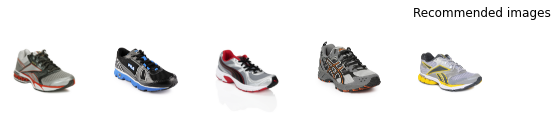

In [18]:
recommendation = get_recommendations(styles_df, sample_similarity_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

# Reusable class for production

In [19]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

class fashion_recommendations:
    """ Production class for recommendations of fashion from similarity """
    
    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
    # Helper functions 
    def get_styles_df(self):
        """ Load a dataframe contains styles details and images """
        styles_df = pd.read_csv(self.styles_path, nrows=6000, error_bad_lines=False) # Read 6000 product and drop bad lines
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
        return styles_df
    
    def load_model(self):
        """ Load our model """
        
        local_weights_file = '/kaggle/input/vgg16weigtht/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        vgg16 = VGG16(include_top=False, weights=local_weights_file, input_shape=(100, 100, 3))
        vgg16.trainable = False
        vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
        return vgg16_model

    def predict(self, model, img_path):
        """ Load and preprocess image then make prediction """
        # Reshape
        img = image.load_img(self.img_path, target_size=(100, 100))
        # img to Array
        img = image.img_to_array(img)
        # Expand Dim (1, w, h)
        img = np.expand_dims(img, axis=0)
        # Pre process Input
        img = preprocess_input(img)
        return model.predict(img)
    
    def get_similarity(self):
        """ Get similarity of custom image """
        model = self.load_model()
        df_embeddings = self.df_embeddings
        sample_image = self.predict(model, self.img_path)
        df_sample_image = pd.DataFrame(sample_image)
        sample_similarity = linear_kernel(df_sample_image, df_embeddings)
        return sample_similarity
    
    def normalize_sim(self):
        """ Normalize similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
        return norm
    
    def get_recommendations(self):
        """ Get recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()
        # Get the pairwsie similarity scores of all clothes with that one (index, value)
        sim_scores = list(enumerate(similarity[0]))

        # Sort the clothes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 5 most similar clothes
        sim_scores = sim_scores[0:5]
        print(sim_scores)
        # Get the clothes indices
        cloth_indices = [i[0] for i in sim_scores]

        # Return the top 5 most similar products
        return df['image'].iloc[cloth_indices]
    
    def print_recommendations(self):
        """ Print the top 5 most similar products"""
        recommendation = self.get_recommendations()
        recommendation_list = recommendation.to_list()
        #recommended images
        plt.figure(figsize=(20,20))
        j=0
        for i in recommendation_list:
            plt.subplot(6, 10, j+1)
            cloth_img =  mpimg.imread("../input/fashion-product-images-dataset/fashion-dataset/" + 'images/'+ i)
            plt.imshow(cloth_img)
            plt.axis("off")
            j+=1
        plt.title("Recommended images",loc='left')
        plt.subplots_adjust(wspace=-0.5, hspace=1)
        plt.show()
        return 

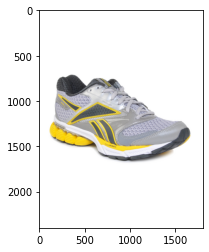

In [20]:
url = "../input/fashion-product-images-dataset/fashion-dataset/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:74: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




[(2848, 1.0), (4477, 0.9401886), (2511, 0.9264021), (1324, 0.9209051), (4393, 0.9207091)]


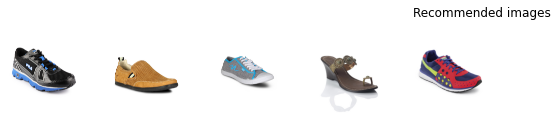

In [21]:
img_path = '../input/fashion-product-images-dataset/fashion-dataset/images/10037.jpg'
styles_path = '../input/fashion-product-images-dataset/fashion-dataset/styles.csv'
obj = fashion_recommendations(img_path, df_embeddings, styles_path)
obj.print_recommendations()


In [22]:
df_embeddings.to_csv('df_embeddings.csv', index=False) 